In [61]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import skimage.transform
from pathlib import Path
from imageio import imread
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
base_dir = 'D:\Solayman\DataSets\computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1'
os.listdir(base_dir)

['ct_ich.yml',
 'ct_scans',
 'hemorrhage_diagnosis_raw_ct.csv',
 'LICENSE.txt',
 'masks',
 'Patient_demographics.csv',
 'Read_me.txt',
 'SHA256SUMS.txt',
 'split_raw_data.py']

In [40]:
dem_path = base_dir + '\\Patient_demographics.csv'
df_dem = pd.read_csv(dem_path)
df_dem.shape

(85, 10)

In [41]:
path_seg = base_dir + '\\masks\\049.nii'
img_seg = nib.load(path_seg)
img_data_seg = img_seg.get_fdata()

In [42]:
df_dem.head()

,Patient Number,Age\n(years),Gender,Hemorrhage type based on the radiologists diagnosis,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Fracture (yes 1/no 0),Note1
0,NaN,NaN,NaN,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,NaN,NaN
1,49.0,35.000,Male,NaN,1,NaN,1,NaN,1.0,NaN
2,50.0,0.583,Female,NaN,1,NaN,NaN,NaN,1.0,NaN
3,51.0,5.000,Male,NaN,1,NaN,NaN,1,1.0,NaN
4,52.0,8.000,Male,NaN,NaN,NaN,1,NaN,1.0,NaN


In [43]:
df_dem['Gender'].value_counts()

Male      46
Female    36
46         1
36         1
Name: Gender, dtype: int64

In [44]:
diag_path = base_dir + '\\hemorrhage_diagnosis_raw_ct.csv'
df_diag = pd.read_csv(diag_path)
df_diag.shape

(2814, 9)

In [45]:
df_diag.head()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No
0,49,1,0,0,0,0,0,1,0
1,49,2,0,0,0,0,0,1,0
2,49,3,0,0,0,0,0,1,0
3,49,4,0,0,0,0,0,1,0
4,49,5,0,0,0,0,0,1,0


In [46]:
df_diag['No_Hemorrhage'].value_counts()

1    2496
0     318
Name: No_Hemorrhage, dtype: int64

In [47]:
df_diag['PatientNumber'].nunique()

75

In [48]:
ct_path = 'D:\\AI_Database\\TBI\\computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1\\ct_scans'
ct_list = os.listdir(ct_path)
len(ct_list)

75

In [49]:
path = base_dir + '\\ct_scans\\049.nii'  
img = nib.load(path)

In [50]:
# here, we're storing the header attribute in a new variable, hdr, for easy of use
hdr = img.header
print(hdr)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 48
dim             : [  3 512 512  39   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.          0.41210938  0.41210938  5.          0.          0.
  0.          0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 2914
glmin           : -1024
descrip         : b'time=--------------.---;'
aux_file        : b';SIEMENS;Head_SAFIRE'
qform_code      : scanner
sform_code      : scanner
quatern_b       : -0.0
quatern_c       : 1.0
quatern_d       : -0.0

In [51]:
hdr.keys()

['sizeof_hdr',
 'data_type',
 'db_name',
 'extents',
 'session_error',
 'regular',
 'dim_info',
 'dim',
 'intent_p1',
 'intent_p2',
 'intent_p3',
 'intent_code',
 'datatype',
 'bitpix',
 'slice_start',
 'pixdim',
 'vox_offset',
 'scl_slope',
 'scl_inter',
 'slice_end',
 'slice_code',
 'xyzt_units',
 'cal_max',
 'cal_min',
 'slice_duration',
 'toffset',
 'glmax',
 'glmin',
 'descrip',
 'aux_file',
 'qform_code',
 'sform_code',
 'quatern_b',
 'quatern_c',
 'quatern_d',
 'qoffset_x',
 'qoffset_y',
 'qoffset_z',
 'srow_x',
 'srow_y',
 'srow_z',
 'intent_name',
 'magic']

In [52]:
hdr.get_xyzt_units()

('mm', 'unknown')

In [53]:
img_data = img.get_fdata()
print(type(img_data))  # it's a 3D numpy array!
print(img_data.shape)

<class 'numpy.memmap'>
(512, 512, 39)


In [54]:
print(img_data)

[[[-995. -993. -996. ... -994. -992. -990.]
  [-995. -995. -996. ... -995. -993. -993.]
  [-995. -996. -996. ... -995. -996. -994.]
  ...
  [-996. -996. -995. ... -992. -993. -992.]
  [-995. -996. -993. ... -991. -992. -992.]
  [-996. -996. -994. ... -991. -991. -992.]]

 [[-996. -994. -996. ... -995. -993. -991.]
  [-996. -995. -996. ... -995. -995. -993.]
  [-996. -996. -996. ... -995. -997. -994.]
  ...
  [-996. -996. -993. ... -992. -994. -992.]
  [-996. -996. -992. ... -991. -992. -993.]
  [-996. -996. -994. ... -990. -990. -992.]]

 [[-996. -996. -997. ... -995. -994. -992.]
  [-996. -996. -996. ... -995. -996. -993.]
  [-996. -996. -996. ... -996. -996. -994.]
  ...
  [-996. -996. -993. ... -992. -994. -993.]
  [-996. -996. -993. ... -990. -994. -994.]
  [-996. -996. -995. ... -990. -992. -993.]]

 ...

 [[-991. -994. -997. ... -998. -998. -996.]
  [-992. -995. -998. ... -998. -998. -997.]
  [-991. -996. -998. ... -998. -997. -998.]
  ...
  [-994. -997. -998. ... -990. -990. -99

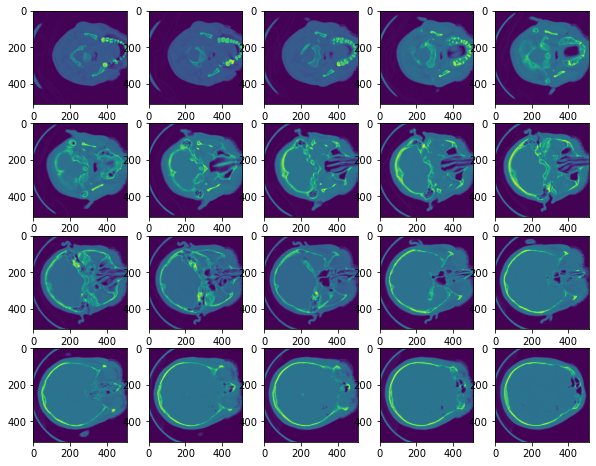

<Figure size 432x288 with 0 Axes>

In [71]:
for i in range(20):
    plt.subplot(5, 5, i + 1)
    plt.imshow(img_data[:,:, i])
    plt.gcf().set_size_inches(10, 10)
plt.show()
plt.savefig('all_raw.png', dpi=300)

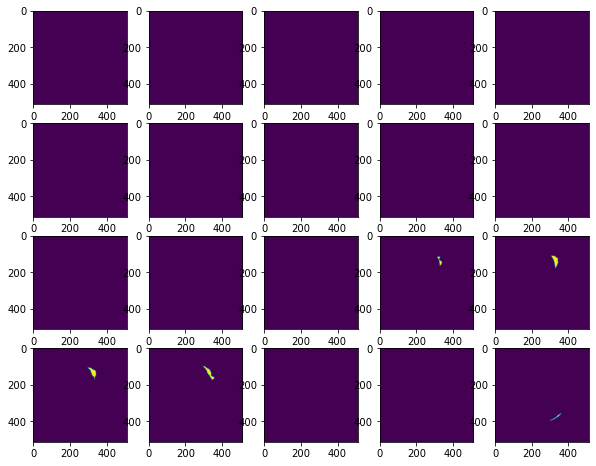

<Figure size 432x288 with 0 Axes>

In [72]:
for i in range(20):
    plt.subplot(5, 5,i + 1)
    plt.imshow(img_data_seg[:,:, i])
    plt.gcf().set_size_inches(10, 10)
plt.show()
plt.savefig('mask.png', dpi=300)

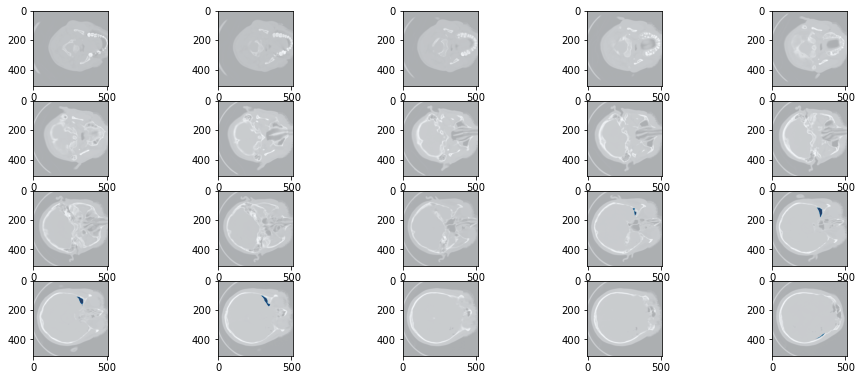

<Figure size 432x288 with 0 Axes>

In [70]:
plt.figure(figsize=(16, 8)) 

for i in range(20):
    plt.subplot(5, 5, i+1)
    plt.imshow(img_data[:,:,i], cmap='gray')
    plt.imshow(img_data_seg[:,:,i], cmap='Blues', alpha=0.7)
plt.show()
plt.savefig('all.png', dpi=50)

In [123]:
df_diag.head(30)

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No
0,49,1,0,0,0,0,0,1,0
1,49,2,0,0,0,0,0,1,0
2,49,3,0,0,0,0,0,1,0
3,49,4,0,0,0,0,0,1,0
4,49,5,0,0,0,0,0,1,0
5,49,6,0,0,0,0,0,1,0
6,49,7,0,0,0,0,0,1,0
7,49,8,0,0,0,0,0,1,0
8,49,9,0,0,0,0,0,1,0
9,49,10,0,0,0,0,0,1,0


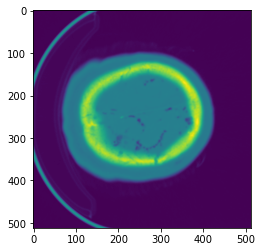

In [124]:
plt.imshow(img_data[:,:,30])

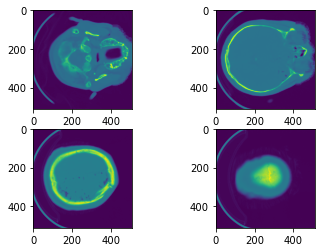

In [125]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(img_data[:,:,4])
axarr[0,1].imshow(img_data[:,:,16])
axarr[1,0].imshow(img_data[:,:,28])
axarr[1,1].imshow(img_data[:,:,33])

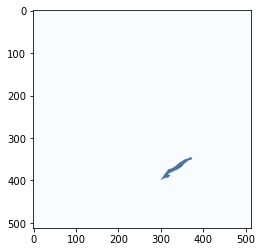

In [126]:
plt.imshow(img_data_seg[:,:,21], cmap='Blues', alpha=0.7)

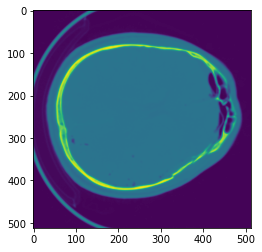

In [127]:
plt.imshow(img_data[:,:,21])

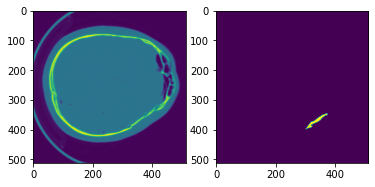

In [65]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img_data[:,:,21])
axarr[1].imshow(img_data_seg[:,:,21])
plt.savefig('combo.png', dpi=300)

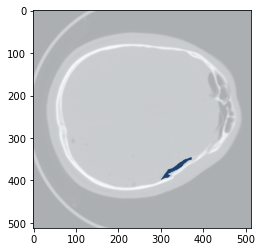

In [63]:
plt.imshow(img_data[:,:,21], cmap='gray')
plt.imshow(img_data_seg[:,:,21], cmap='Blues', alpha=0.7)
plt.savefig('output.png', dpi=300)

In [59]:
def window_ct (ct_scan, w_level=40, w_width=120):
    w_min = w_level - w_width / 2
    w_max = w_level + w_width / 2
    num_slices=ct_scan.shape[2]
    for s in range(num_slices):
        slice_s = ct_scan[:,:,s]
        slice_s = (slice_s - w_min)*(255/(w_max-w_min)) #or slice_s = (slice_s - (w_level-(w_width/2)))*(255/(w_width))
        slice_s[slice_s < 0]=0
        slice_s[slice_s > 255] = 255
        #slice_s=np.rot90(slice_s)
        ct_scan[:,:,s] = slice_s

    return ct_scan

In [55]:
numSubj = 75
new_size = (512, 512)
window_specs=[40,120] #Brain window
currentDir = Path(os.getcwd()) 
print(currentDir)
# Change the current working directory
os.chdir('D://Solayman//DataSets//computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1')
currentDir = Path(os.getcwd()) 
print(currentDir)
datasetDir = str(base_dir)

D:\Solayman\DataSets\computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1
D:\Solayman\DataSets\computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1


In [56]:
# Reading labels
hemorrhage_diagnosis_array = df_diag._get_values

In [57]:
# reading images

train_path = Path('data')
print(train_path)
image_path = train_path / 'image'
label_path = train_path / 'label'
if not train_path.exists():
    train_path.mkdir()
    image_path.mkdir()
    label_path.mkdir()

data


In [62]:
counterI = 0

for sNo in range(0+49, numSubj+49):
    if sNo>58 and sNo<66: #no raw data were available for these subjects
        next
    else:
        #Loading the CT scan
        ct_dir_subj = Path(datasetDir,'ct_scans', "{0:0=3d}.nii".format(sNo))
        ct_scan_nifti = nib.load(str(ct_dir_subj))
        ct_scan = ct_scan_nifti.get_data()
        ct_scan = window_ct(ct_scan, window_specs[0], window_specs[1])

        #Loading the masks
        masks_dir_subj = Path(datasetDir,'masks', "{0:0=3d}.nii".format(sNo))
        masks_nifti = nib.load(str(masks_dir_subj))
        masks = masks_nifti.get_data()
        idx = hemorrhage_diagnosis_array[:, 0] == sNo
        sliceNos = hemorrhage_diagnosis_array[idx, 1]
        NoHemorrhage = hemorrhage_diagnosis_array[idx, 7]
        if sliceNos.size!=ct_scan.shape[2]:
            print('Warning: the number of annotated slices does not equal the number of slices in NIFTI file!')

        for sliceI in range(0, sliceNos.size):
            # Saving the a given CT slice
            #x = imresize(ct_scan[:,:,sliceI], new_size)
            x = skimage.transform.resize(ct_scan[:,:,sliceI], new_size)
            plt.imsave(image_path / (str(counterI) + '.png'), x)

            # Saving the segmentation for a given slice
            segment_path = Path(masks_dir_subj,str(sliceNos[sliceI]) + '_HGE_Seg.jpg')
            x = skimage.transform.resize(masks[:,:,sliceI], new_size)
            plt.imsave(label_path / (str(counterI) + '.png'), x)
            counterI = counterI+1

<ipython-input-62-1df0a428ee5a>:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  ct_scan = ct_scan_nifti.get_data()
<ipython-input-62-1df0a428ee5a>:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  masks = masks_nifti.get_data()
<ipython-input-62-1df0a428ee5a>:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecate

<ipython-input-62-1df0a428ee5a>:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  ct_scan = ct_scan_nifti.get_data()
<ipython-input-62-1df0a428ee5a>:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  masks = masks_nifti.get_data()
<ipython-input-62-1df0a428ee5a>:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecate

<ipython-input-62-1df0a428ee5a>:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  ct_scan = ct_scan_nifti.get_data()
<ipython-input-62-1df0a428ee5a>:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  masks = masks_nifti.get_data()
<ipython-input-62-1df0a428ee5a>:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecate

<ipython-input-62-1df0a428ee5a>:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  ct_scan = ct_scan_nifti.get_data()
<ipython-input-62-1df0a428ee5a>:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  masks = masks_nifti.get_data()
<ipython-input-62-1df0a428ee5a>:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecate